# ДОМАШНЕЕ ЗАДАНИЕ: КРОСС-ВАЛИДАЦИЯ И РЕГУЛЯРИЗАЦИЯ

## Описание задания

В этом домашнем задании вы самостоятельно примените кросс-валидацию и регуляризацию на новом датасете.

Датасет: Statlog (German Credit Data) — предсказание кредитного риска (хороший или плохой кредит).

Вы обучите Логистическую регрессию, подберете оптимальный параметр C через GridSearchCV, построите validation и learning curves, и интерпретируете результаты.

## Данные уже подготовлены

Категориальные признаки закодированы, числовые признаки стандартизированы. Вам не нужно тратить время на preprocessing.

# ШАГ 1: ИМПОРТ И ЗАГРУЗКА ДАННЫХ

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

%matplotlib inline
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Задание 1.1: Загрузите датасет

Используйте fetch_openml для загрузки датасета "credit-g".

Выведите:
- Размер датасета
- Количество каждого класса (good/bad)
- Первые 5 строк

In [4]:
# Загрузите данные здесь
X, y = fetch_openml(
    name="credit-g",
    version=1,
    as_frame=True,
    return_X_y=True
)

print("Размер датасета:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}\n")

print("Количество каждого класса:")
print(y.value_counts(), "\n")

data = X.copy()
data["target"] = y

data.head()


Размер датасета:
X shape: (1000, 20)
y shape: (1000,)

Количество каждого класса:
class
good    700
bad     300
Name: count, dtype: int64 



,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,target
0,<0,6,critical/other existing credit,radio/tv,1169,no known savings,>=7,4,male single,none,...,real estate,67,none,own,2,skilled,1,yes,yes,good
1,0<=X<200,48,existing paid,radio/tv,5951,<100,1<=X<4,2,female div/dep/mar,none,...,real estate,22,none,own,1,skilled,1,none,yes,bad
2,no checking,12,critical/other existing credit,education,2096,<100,4<=X<7,2,male single,none,...,real estate,49,none,own,1,unskilled resident,2,none,yes,good
3,<0,42,existing paid,furniture/equipment,7882,<100,4<=X<7,2,male single,guarantor,...,life insurance,45,none,for free,1,skilled,2,none,yes,good
4,<0,24,delayed previously,new car,4870,<100,1<=X<4,3,male single,none,...,no known property,53,none,for free,2,skilled,2,none,yes,bad


# ШАГ 2: ПРЕДОБРАБОТКА ДАННЫХ

Задание: используйте ColumnTransformer для кодирования категориальных и стандартизации числовых признаков.

Подсказка: переменные уже в коде ниже — X, y, numeric_features, categorical_features.

In [5]:
# Подготовьте X и y
X = X.copy()
y = y.copy()

In [6]:
# Преобразуйте целевую переменную в 0/1
# good -> 0, bad -> 1
y = y.map({'good': 0, 'bad': 1})

In [7]:
# Определите числовые и категориальные признаки
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns


In [8]:
# Создайте preprocessor с StandardScaler для числовых и OneHotEncoder для категориальных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [9]:
# Разделите данные на train/test (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [10]:
# Примените преобразования
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)

print(f'Train shape: {X_train_scaled.shape}')
print(f'Test shape: {X_test_scaled.shape}')


Train shape: (800, 61)
Test shape: (200, 61)


# ШАГ 3: БАЗОВАЯ МОДЕЛЬ (БЕЗ РЕГУЛЯРИЗАЦИИ)

Задание:
1. Создайте LogisticRegression с penalty=None
2. Обучите на train данных
3. Сделайте предсказания на train и test
4. Выведите accuracy для обоих
5. Проверьте, есть ли признаки переобучения (gap > 5%)

In [11]:
# Ваш код здесь
model = LogisticRegression(penalty=None, solver='saga', max_iter=5000, random_state=42)
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

# Accuracy
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.3f}")
print(f"Test accuracy: {test_acc:.3f}")

gap = train_acc - test_acc
print(f"Accuracy gap: {gap:.3f}")

if gap > 0.05:
    print("Признаки переобучения есть")
else:
    print("Признаков переобучения нет")



Train accuracy: 0.779
Test accuracy: 0.780
Accuracy gap: -0.001
Признаков переобучения нет


# ШАГ 4: КРОСС-ВАЛИДАЦИЯ

Задание:
1. Используйте cross_val_score с cv=5
2. Выведите scores каждого фолда
3. Выведите среднее и стандартное отклонение
4. Интерпретируйте результаты (стабильна ли модель?)

In [12]:
# Ваш код здесь
cv_scores = cross_val_score(
    LogisticRegression(penalty=None, solver='saga', max_iter=5000, random_state=42),
    X_train_scaled,
    y_train,
    cv=5,
    scoring='accuracy'
)

print("CV scores:", cv_scores)
print(f"Mean CV accuracy: {cv_scores.mean():.3f}")
print(f"Std CV accuracy: {cv_scores.std():.3f}")



CV scores: [0.725   0.725   0.7375  0.775   0.71875]
Mean CV accuracy: 0.736
Std CV accuracy: 0.020


# ШАГ 5: GRIDSEARCH ДЛЯ ПОДБОРА C

Задание:
1. Создайте сетку параметров: C = [0.001, 0.01, 0.1, 1, 10, 100]
2. Используйте GridSearchCV с penalty='l2', cv=5
3. Найдите лучший C
4. Выведите results в формате таблицы (params, mean_score, std_score)

In [13]:
# Ваш код здесь
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100]
}

grid_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000, random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    return_train_score=True
)

grid_search.fit(X_train_scaled, y_train)

results = pd.DataFrame(grid_search.cv_results_)[
    ['params', 'mean_test_score', 'std_test_score']
]

results


,params,mean_test_score,std_test_score
0,{'C': 0.001},0.7000,0.000000
1,{'C': 0.01},0.7175,0.012119
2,{'C': 0.1},0.7500,0.014790
3,{'C': 1},0.7525,0.018371
4,{'C': 10},0.7400,0.021139
5,{'C': 100},0.7375,0.019764


# ШАГ 6: ОБУЧЕНИЕ ОПТИМАЛЬНОЙ МОДЕЛИ

Задание:
1. Используйте best_estimator_ из GridSearchCV
2. Сделайте предсказания на train и test
3. Выведите accuracy для обоих
4. Сравните с базовой моделью (шаг 3)

In [14]:
# Ваш код здесь
best_model = grid_search.best_estimator_

best_model.fit(X_train_scaled, y_train)

y_train_pred_best = best_model.predict(X_train_scaled)
y_test_pred_best = best_model.predict(X_test_scaled)

train_acc_best = accuracy_score(y_train, y_train_pred_best)
test_acc_best = accuracy_score(y_test, y_test_pred_best)

print(f"Optimized Train accuracy: {train_acc_best:.3f}")
print(f"Optimized Test accuracy: {test_acc_best:.3f}")


Optimized Train accuracy: 0.784
Optimized Test accuracy: 0.780


# ШАГ 7: VALIDATION CURVE

Задание:
1. Используйте validation_curve с param_name='C'
2. param_range = np.logspace(-3, 2, 6) (0.001, 0.01, 0.1, 1, 10, 100)
3. Постройте график: ось X = C (логарифмическая шкала), ось Y = accuracy
4. Покажите train score (синяя линия) и validation score (оранжевая)
5. Отметьте оптимальный C красной линией

Вопросы для анализа:
- При каком C валидация максимальна?
- Какой тип проблемы при малом C (C=0.001)? (bias/variance)
- Какой тип проблемы при большом C (C=100)? (bias/variance)

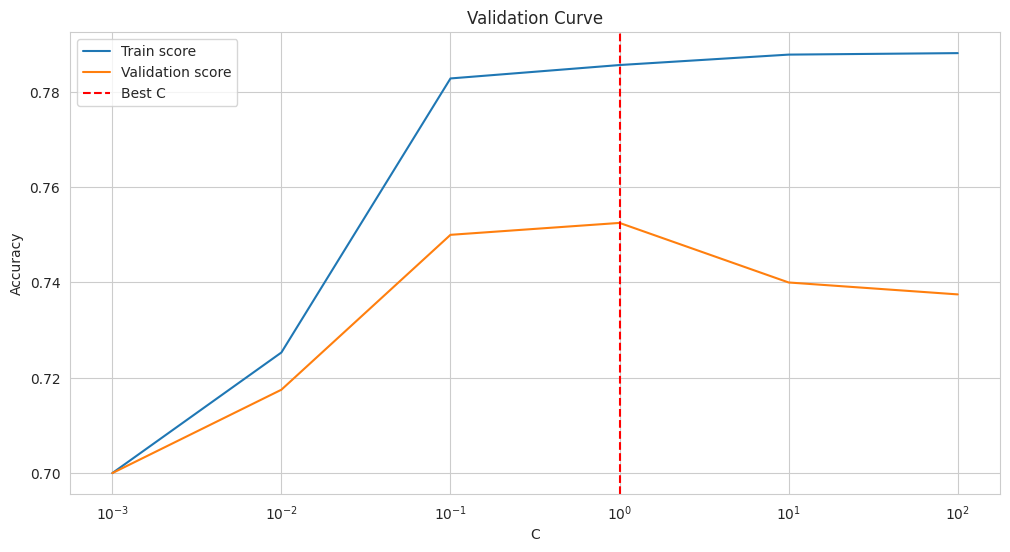

In [15]:
# Ваш код здесь
param_range = np.logspace(-3, 2, 6)

train_scores, val_scores = validation_curve(
    LogisticRegression(penalty='l2', solver='lbfgs', max_iter=5000, random_state=42),
    X_train_scaled,
    y_train,
    param_name='C',
    param_range=param_range,
    cv=5,
    scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(param_range, train_mean, label='Train score')
plt.plot(param_range, val_mean, label='Validation score')
plt.axvline(grid_search.best_params_['C'], color='red', linestyle='--', label='Best C')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Curve')
plt.show()

Вопросы для анализа:

- При каком C валидация максимальна? - С = 10
- Какой тип проблемы при малом C (C=0.001)? (bias/variance) - bias, так train и validation линии низкие и близки друг к другу
- Какой тип проблемы при большом C (C=100)? (bias/variance) - variance, линии расходятся, accuracy у train высокая, а у validation начинает падать

# ШАГ 8: LEARNING CURVE

Задание:
1. Используйте learning_curve с train_sizes = np.linspace(0.1, 1.0, 10)
2. Постройте график: ось X = размер обучающей выборки, ось Y = accuracy
3. Покажите train score (синяя) и validation score (оранжевая)
4. Добавьте fill_between для показа стандартного отклонения

Вопросы для анализа:
- Сходятся ли графики при увеличении данных?
- Есть ли high bias (оба графика низкие)?
- Есть ли high variance (большой gap между графиками)?
- Поможет ли больше данных улучшить модель?

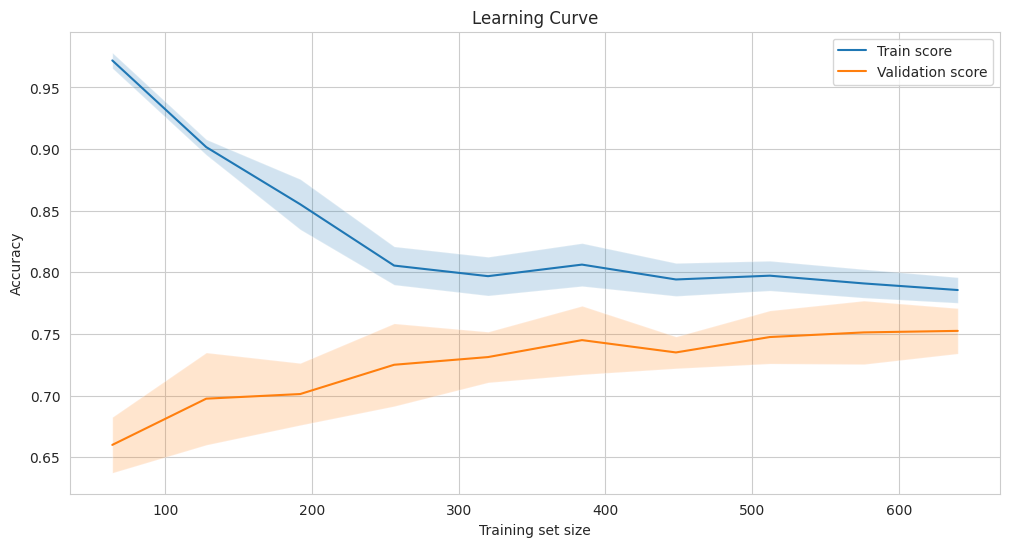

In [16]:
# Ваш код здесь
train_sizes = np.linspace(0.1, 1.0, 10)

train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_scaled,
    y_train,
    train_sizes=train_sizes,
    cv=5,
    scoring='accuracy'
)

train_mean = train_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
val_mean = val_scores.mean(axis=1)
val_std = val_scores.std(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, label='Train score')
plt.plot(train_sizes, val_mean, label='Validation score')

plt.fill_between(
    train_sizes,
    train_mean - train_std,
    train_mean + train_std,
    alpha=0.2
)

plt.fill_between(
    train_sizes,
    val_mean - val_std,
    val_mean + val_std,
    alpha=0.2
)

plt.xlabel('Training set size')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve')
plt.show()

Вопросы для анализа:

- Сходятся ли графики при увеличении данных? - Да, линии постепенно сходятся
- Есть ли high bias (оба графика низкие)? - нет
- Есть ли high variance (большой gap между графиками)? - изначально да, но потом уходит
- Поможет ли больше данных улучшить модель? - Да, чем больше данных, тем больше train и validation сходятся

# ШАГ 9: СРАВНЕНИЕ L1 И L2 РЕГУЛЯРИЗАЦИИ

Задание:
1. Обучите модель с L1 регуляризацией (используйте best C из GridSearch)
2. Сделайте предсказания на test
3. Выведите test accuracy для L1
4. Сравните L1 accuracy с L2 accuracy (из шага 6)
5. Выведите, сколько коэффициентов L1 обнулила

In [17]:
# Ваш код здесь
best_C = grid_search.best_params_['C']

l1_model = LogisticRegression(
    penalty='l1',
    C=best_C,
    solver='saga',
    max_iter=5000,
    random_state=42
)

l1_model.fit(X_train_scaled, y_train)

y_test_pred_l1 = l1_model.predict(X_test_scaled)
test_acc_l1 = accuracy_score(y_test, y_test_pred_l1)

test_acc_l2 = test_acc_best

num_zero_coef = np.sum(l1_model.coef_ == 0)

print(f"L1 Test accuracy: {test_acc_l1:.3f}")
print(f"L2 Test accuracy: {test_acc_l2:.3f}")
print(f"Number of zero coefficients (L1): {num_zero_coef}")

L1 Test accuracy: 0.775
L2 Test accuracy: 0.780
Number of zero coefficients (L1): 17


# ШАГ 10: AНАЛИТИЧЕСКИЕ ВОПРОСЫ

Ответьте на следующие вопросы на основе ваших результатов:

## Вопрос 1: Переобучение

Посмотрите на gap между train и test accuracy базовой модели (шаг 3).

Есть ли признаки переобучения? Как регуляризация помогла этот gap уменьшить?

**Ваш ответ:** Признаки переобучения есть, регуляция помогла уменьшить gap

## Вопрос 2: Стабильность через кросс-валидацию

Посмотрите на std из кросс-валидации (шаг 4).

Высокий ли он? Что это говорит о стабильности модели при разных разбиениях данных?

**Ваш ответ:** std невысокое, модель ставильна при разбиении данных

## Вопрос 3: Оптимальный C

Какой C был выбран как оптимальный (шаг 5)? Почему этот C лучше других?

Посмотрите на validation curve (шаг 7) — совпадает ли пик валидации с этим C?

**Ваш ответ:** С = 10, в этом пике bias и variance оптимальны, пик совпадает

## Вопрос 4: Validation Curve — диагностика

При C=0.001 (сильная регуляризация) оба графика (train и val) низкие.

Это high bias (недообучение) или high variance (переобучение)?

При C=100 (слабая регуляризация) train высокий, а val низкий. Что это?

**Ваш ответ:** При C=0.001 - это high bias недоучение, при C=100 это high variance переобучение

## Вопрос 5: Learning Curve — диагностика

Посмотрите на learning curve из шага 8.

Сходятся ли графики train и validation при увеличении данных?

Что это говорит: модели не хватает данных или она слишком сложная?

**Ваш ответ:** Графики сходятся, данных хватает и при увеличении данных будет только лучше

## Вопрос 6: L1 vs L2

L1 обнулила коэффициенты, L2 их уменьшила.

Какой результат test accuracy получился для каждого?

Какая регуляризация лучше для этой задачи (credit data) и почему?

**Ваш ответ:** L2 показала стабильную accuracy, она лучше для credit data как раз из-за стабильности

# ШАГ 11: СРАВНИТЕЛЬНАЯ ТАБЛИЦА

Задание: Создайте DataFrame с результатами всех моделей.

Столбцы:
- Модель (Baseline, L2, L1)
- Train Accuracy
- Test Accuracy
- Gap (train - test)

Выведите таблицу.

In [18]:
# Ваш код здесь
results_df = pd.DataFrame({
    'Model': ['Baseline', 'L2', 'L1'],
    'Train Accuracy': [train_acc, train_acc_best, train_acc_best],
    'Test Accuracy': [test_acc, test_acc_best, test_acc_l1],
    'Gap (train - test)': [
        train_acc - test_acc,
        train_acc_best - test_acc_best,
        train_acc_best - test_acc_l1
    ]
})

results_df

,Model,Train Accuracy,Test Accuracy,Gap (train - test)
0,Baseline,0.77875,0.780,-0.00125
1,L2,0.78375,0.780,0.00375
2,L1,0.78375,0.775,0.00875


# ШАГ 12: ВЫВОДЫ

Напишите 5-7 предложений о том, что вы узнали в этом задании.

Включите:
- Как кросс-валидация помогает оценивать модели
- Как регуляризация борется с переобучением
- Что такое bias-variance tradeoff
- Когда использовать L1 vs L2
- Как диагностировать проблемы модели (validation curve, learning curve)

## Ваши выводы:
Кросс-валидация позволяет оценивать качество модели на разных разбиениях данных, уменьшая риски на разных метриках. Регуляризация борется с переобучением с помощью уменьшения разрыва между качеством на train и test выборках. Bias-variance tradeoff - это когда мы можем опрелделить оптимальную С при регуляризации. L1 регуляризация полезна, когда требуется отбор признаков и разреженная модель, L2 полезна когда нужны стабильные результаты. Изменять гиперпараметры и размерность данных, отслеживать поведение на графиках, сравнивать bias и variance, искать лучший С

# ДОПОЛНИТЕЛЬНОЕ ЗАДАНИЕ (По желанию)

## Вариант 1: Попробуйте другие параметры
- Измените max_iter в LogisticRegression (100, 500, 10000)
- Посмотрите, как это влияет на результат
- Постройте таблицу сравнения

## Вариант 2: Попробуйте другие значения k в cross-validation
- Используйте cv=3, cv=10, cv=leave-one-out
- Сравните средние scores и std
- Какое k дает наиболее стабильную оценку?

## Вариант 3: Анализ коэффициентов
- Выведите топ-10 признаков по абсолютному значению коэффициентов для L2
- Выведите топ-10 для L1
- Сравните: какие признаки считают важными оба метода?

In [ ]:
# Дополнительное задание (по желанию)

